# Consultas SQL con PySpark

Introducción

Una de las características principales de `Spark` es su capacidad para ejecutar consultas SQL en datos estructurados. En esta publicación del blog, exploraremos cómo ejecutar consultas `SQL` en `PySpark` y brindaremos un código de ejemplo para comenzar. Al final de esta publicación, debería comprender mejor cómo trabajar con consultas `SQL` en `PySpark`.

## Contenido

1. Configuración de PySpark
2. Carga de datos en un DataFrame
3. Creación de una vista temporal
4. Ejecución de consultas SQL
5. Ejemplo: análisis de datos de ventas

Empezamos creando el `SparkSession`

In [0]:
from pyspark.sql import SparkSession
import requests
import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')
sns.set_style("whitegrid")

In [0]:
spark = SparkSession.builder \
    .appName("Running SQL Queries in PySpark") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

## Carga de datos en un DataFrame

Para ejecutar consultas SQL en PySpark, primero deberá cargar sus datos en un DataFrame. Los DataFrames son la estructura de datos principal en Spark y se pueden crear a partir de varias fuentes de datos, como archivos CSV, JSON y Parquet, así como tablas de Hive y bases de datos JDBC.

Por ejemplo, para cargar un archivo CSV en un DataFrame, puede usar el siguiente código

In [0]:
df_url = "https://raw.githubusercontent.com/narencastellon/databricks_pyspark/refs/heads/main/data/train_dataset_sql.csv"

df2_path = "https://raw.githubusercontent.com/narencastellon/databricks_pyspark/refs/heads/main/data/train_salaries_sql.csv" 



In [0]:
# Download the CSV file using requests
response = requests.get(df_url)
response.raise_for_status()  # Raise an exception for bad responses

# Read the CSV data into a Pandas DataFrame
train_dataset = pd.read_csv(io.StringIO(response.text), sep=',')

# Convert the Pandas DataFrame to a Spark DataFrame
df1 = spark.createDataFrame(train_dataset)

df1.show()

+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|   PHYSICS|   HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|   PHYSICS|  FINANCE|              8|                 16|
|JOB1362684407692|   COMP15|       MANAGER|   DOCTORAL|   COMPSCI|  FINANCE|              2|    

In [0]:
# Download the CSV file using requests
response = requests.get(df2_path)
response.raise_for_status()  # Raise an exception for bad responses

# Read the CSV data into a Pandas DataFrame
train_salaries = pd.read_csv(io.StringIO(response.text), sep=',')

# Convert the Pandas DataFrame to a Spark DataFrame
df2 = spark.createDataFrame(train_salaries)

df2.show()

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
|JOB1362684407692|   113|
|JOB1362684407693|   178|
|JOB1362684407694|    73|
|JOB1362684407695|    31|
|JOB1362684407696|   104|
|JOB1362684407697|   102|
|JOB1362684407698|   144|
|JOB1362684407699|    79|
|JOB1362684407700|   193|
|JOB1362684407701|    47|
|JOB1362684407702|   172|
|JOB1362684407703|    47|
|JOB1362684407704|   126|
|JOB1362684407705|   122|
|JOB1362684407706|    95|
+----------------+------+
only showing top 20 rows



También podemos obtener información sobre los tipos de columnas:

In [0]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: long (nullable = true)
 |-- milesFromMetropolis: long (nullable = true)



In [0]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: long (nullable = true)



Al imprimir el esquema df, podemos ver que algunas características como `salary`, `yearsExperience` y `milesFromMetropolis` deben convertirse al tipo entero.

In [0]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [0]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [0]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [0]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



Antes de comenzar el análisis, uniremos los dos marcos de datos en jobid. Si unimos los dos marcos de datos tal como están, tendremos dos columnas jobId idénticas, lo que creará ambigüedad. Por este motivo, cambiaremos el nombre de la columna JobId en el segundo marco de datos, de modo que podamos eliminarla después de la unión sin crear ambigüedad con la columna jobId del primer marco de datos.

In [0]:
df2 = df2.withColumnRenamed('jobId', 'job_id')

In [0]:
df = df1.join(df2, df1.jobId==df2.job_id)

In [0]:
df.show(5)

+----------------+---------+--------------+-----------+--------+--------+---------------+-------------------+----------------+------+
|           jobId|companyId|       jobType|     degree|   major|industry|yearsExperience|milesFromMetropolis|          job_id|salary|
+----------------+---------+--------------+-----------+--------+--------+---------------+-------------------+----------------+------+
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|    NONE|     WEB|              3|                 73|JOB1362684407688|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|    NONE|  HEALTH|             23|                 24|JOB1362684407693|   178|
|JOB1362684407724|    COMP8|VICE_PRESIDENT|   DOCTORAL|BUSINESS|  HEALTH|             24|                 35|JOB1362684407724|   183|
|JOB1362684407739|    COMP5|        JUNIOR|    MASTERS| BIOLOGY| FINANCE|             11|                 72|JOB1362684407739|    88|
|JOB1362684407741|   COMP44|       JANITOR|HIGH_SCHOOL|    NON

## Comprobación de datos duplicados

In [0]:
df_dup = df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")

df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



## Comprobación de valores faltantes

In [0]:
df.show(10)

+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+----------------+------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|          job_id|salary|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+----------------+------+
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|JOB1362684407688|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|      NONE|   HEALTH|             23|                 24|JOB1362684407693|   178|
|JOB1362684407724|    COMP8|VICE_PRESIDENT|   DOCTORAL|  BUSINESS|   HEALTH|             24|                 35|JOB1362684407724|   183|
|JOB1362684407739|    COMP5|        JUNIOR|    MASTERS|   BIOLOGY|  FINANCE|             11|                 72|JOB1362684407739|    88|
|JOB1362684407741|   COMP44|       JANITO

Podemos ver que algunas columnas tienen valores `NONE`, ¿son estos valores faltantes?

In [0]:
print('Número de valores faltantes para jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Número de valores faltantes para degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Número de valores faltantes para major: {}'.format(df.filter(df.major=='NONE').count()))
print('Número de valores faltantes para industry: {}'.format(df.filter(df.industry=='NONE').count()))

Número de valores faltantes para jobType: 0
Número de valores faltantes para degree: 236854
Número de valores faltantes para major: 532355
Número de valores faltantes para industry: 0


En realidad, no son valores faltantes. Indican que el trabajador no tiene título o especialidad, por ejemplo. No descartaremos estos valores.

## Dataset Analayis

Podemos obtener información básica sobre las columnas numéricas llamando al método describe

In [0]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885733|  28.87773262871997|38.71793638113317|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



El salario mínimo parece ser 0, ¿tiene esto que ver con los trabajos de voluntariado? ¡Esto se investigará más adelante!

**¿Cuál es el trabajo mejor pagado?**

Para realizar consultas SQL en el conjunto de datos, debemos crear una tabla basada en el marco de datos spark, de la siguiente manera:

In [0]:
df.createOrReplaceTempView("data")

In [0]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



Los trabajos mejor pagados son los de CFO (director financiero) y CTO (director de tecnología) en la industria petrolera, con un salario de 301k$.

¿Cuáles son los 20 trabajos con mayor salario en el TOP 20?

In [0]:
df_q2 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO| FINANCE|   1|
|   294|    CEO|     OIL|   4|
|   293|    CEO| FINANCE|   2|
|   293|    CEO|     OIL|   5|
|   292|    CTO| FINANCE|   3|
|   292|    CEO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CEO| FINANCE|   5|
|   289|    CFO|     OIL|   6|
|   289|    CTO|     WEB|   2|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+



Podemos encontrar el resultado anterior (obtenido con una subconsulta) de los empleos mejor pagados, en particular podemos ver que 8 de los TOP20 empleos mejor pagados son del sector PETRÓLEO (5 de ellos en el TOP10), 10 son del sector FINANZAS y 2 son del sector WEB. También agregamos una columna Rank para mejorar la legibilidad del resultado.

¿Cuál es el trabajo peor pagado?

In [0]:
spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|       MANAGER|  FINANCE|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|        JUNIOR|      OIL|   1|
|     0|           CTO|     AUTO|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



Podemos ver claramente que los trabajos con salario 0$ probablemente sean valores faltantes, ya que están relacionados, por ejemplo, con las industrias del petróleo y la web, que están muy bien pagadas (como se vio antes). Además, también hay un trabajo de "vicepresidente", que es imposible que tenga salario 0$. Omitiremos estas filas.

In [0]:
df = df.where("salary != 0")

Luego, también necesitamos volver a cargar la tabla ya que actualizamos el marco de datos df.

In [0]:
df.createOrReplaceTempView("data")

In [0]:
df_q3 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''')
df_q3.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
+------+-------+---------+----+
only showing top 20 rows



Podemos ver que ahora el trabajo peor pagado es el de conserje, con un salario mínimo de 17k$.

¿Cuáles son las 3 principales industrias en términos de salarios más altos?

In [0]:
df_q4 = spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(10)

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



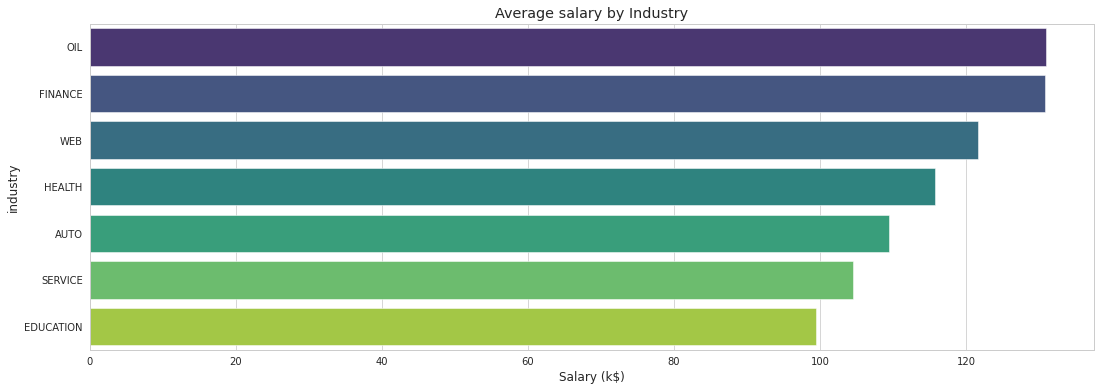

In [0]:
df_p = df_q4.toPandas()
plt.figure(figsize=(18, 6))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

Podemos ver que las dos primeras industrias son el petróleo y las finanzas, que tienen un salario promedio muy similar de 130 000 dólares. La tercera industria en términos de salario más alto es la web. Podríamos esperar este resultado si analizamos el resultado de la consulta del primer trimestre.

¿Los trabajadores con más años de experiencia ganan más?

In [0]:
df_q5 = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''') 
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO| FINANCE|             24|
|   294|    CEO|     OIL|             19|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CEO| FINANCE|             23|
|   289|    CFO|     OIL|             23|
|   289|    CTO|     WEB|             24|
|   288|    CFO| FINANCE|             21|
|   288|    CFO| FINANCE|             24|
|   287|    CEO|     OIL|             22|
|   287|    CEO| FINANCE|             19|
|   286|    CEO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
|   286|    CTO| FINANCE|             24|
+------+-------+--------+---------

Para mejorar la legibilidad de los resultados, representaremos gráficamente el salario frente al tipo de trabajo. Antes de hacerlo, debemos comprobar los diferentes tipos de trabajo en el marco de datos:

In [0]:
df_q5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [0]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

A continuación, debemos convertir el marco de datos extraído por la consulta SQL Q5 en un marco de datos de pandas:

In [0]:
df_p = df_q5.toPandas()

¿Los trabajadores con títulos superiores tienen empleos mejor pagados?

In [0]:
df_q6 = spark.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|       NONE|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



Podemos ver algunos valores `NONE` en la columna de grado: eliminaremos las filas sin grado.

In [0]:
df_q6 = df_q6.replace('NONE',None)

In [0]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       null|    17|JANITOR|
|       null|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       null|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [0]:
df_q6 = df_q6.na.drop()

In [0]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [0]:
df_q6.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [0]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

Finalmente, podemos convertir el marco de datos extraído por la consulta SQL 'Q6' en un marco de datos de pandas para trazar el resultado deseado.

In [0]:
df_p = df_q6.toPandas()

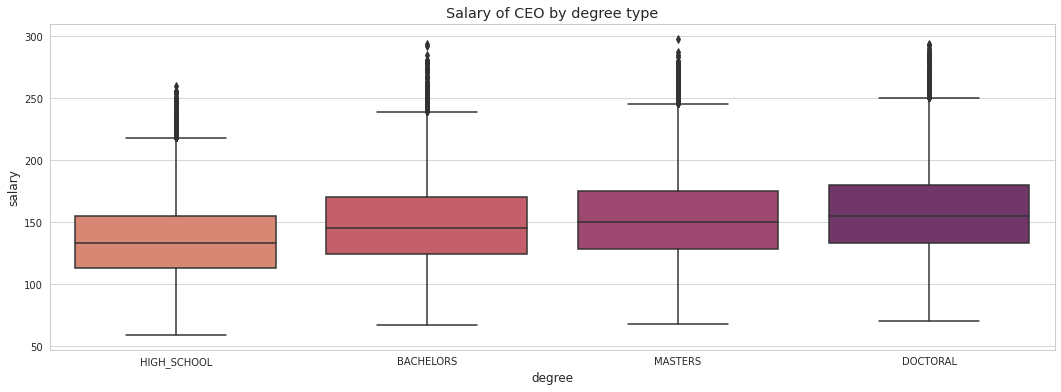

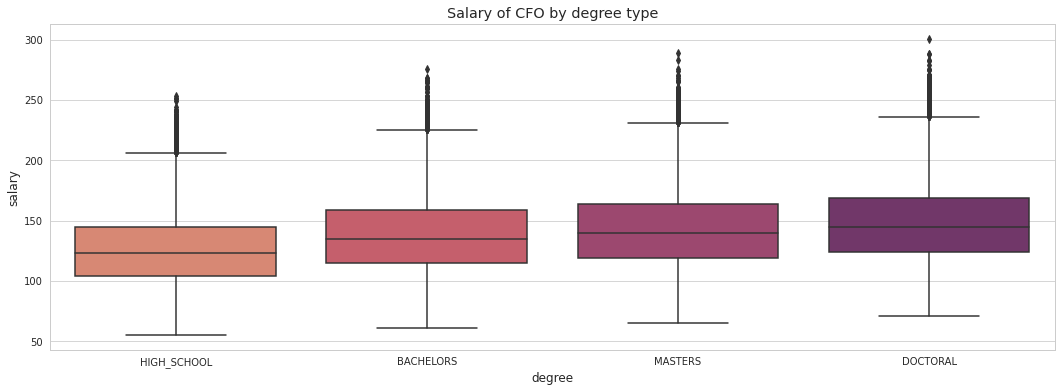

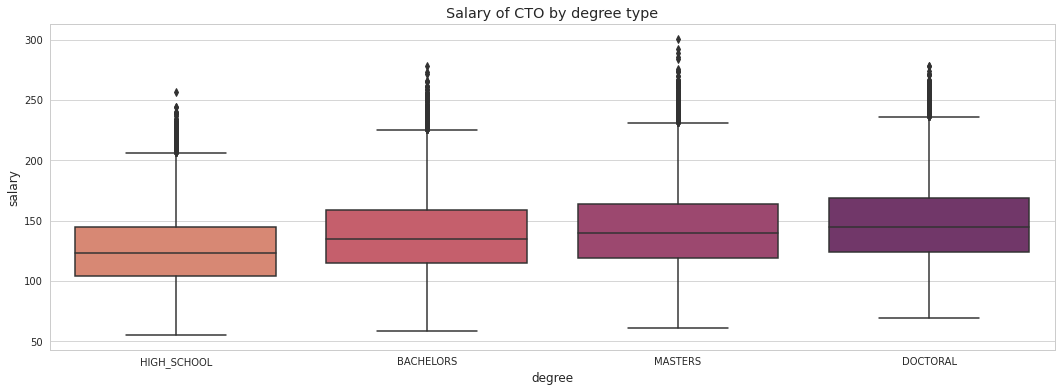

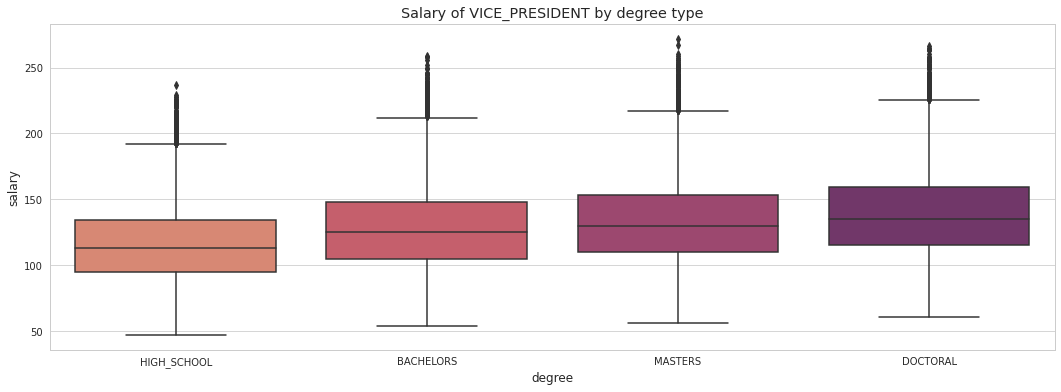

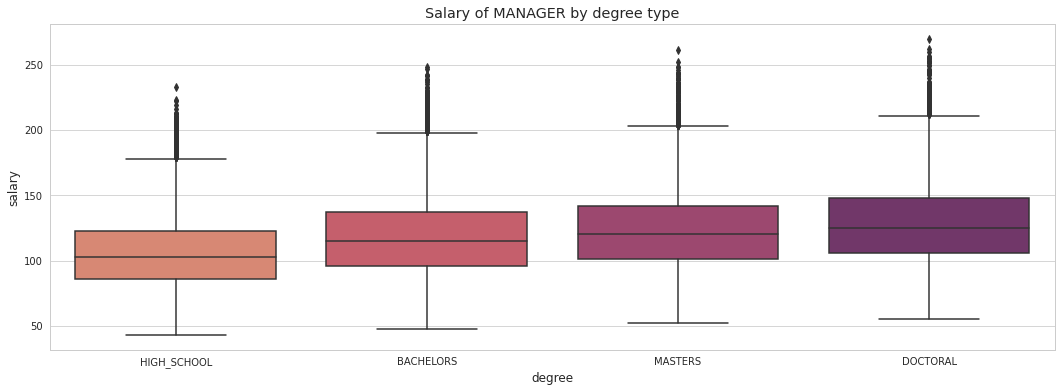

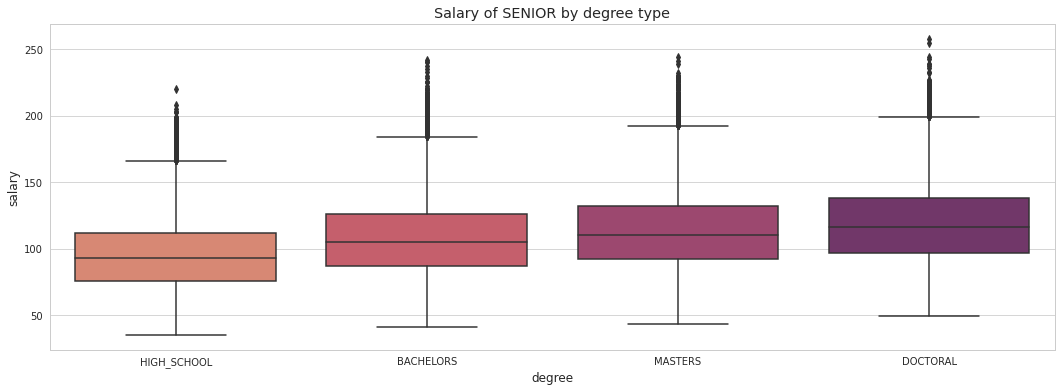

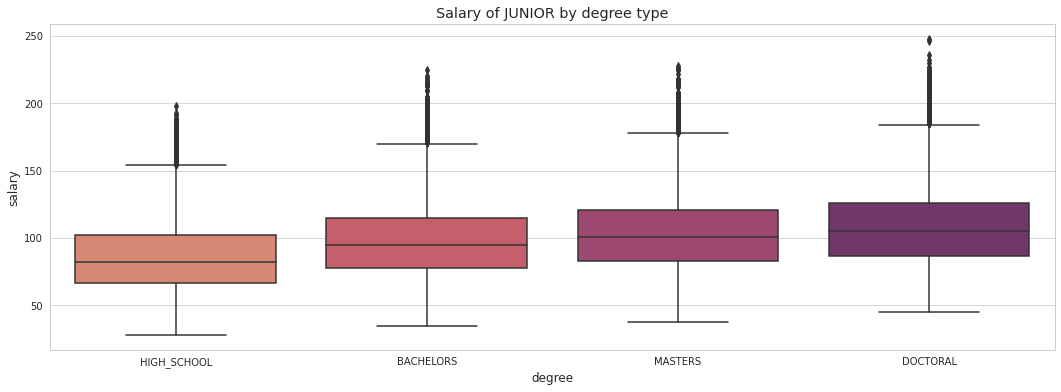

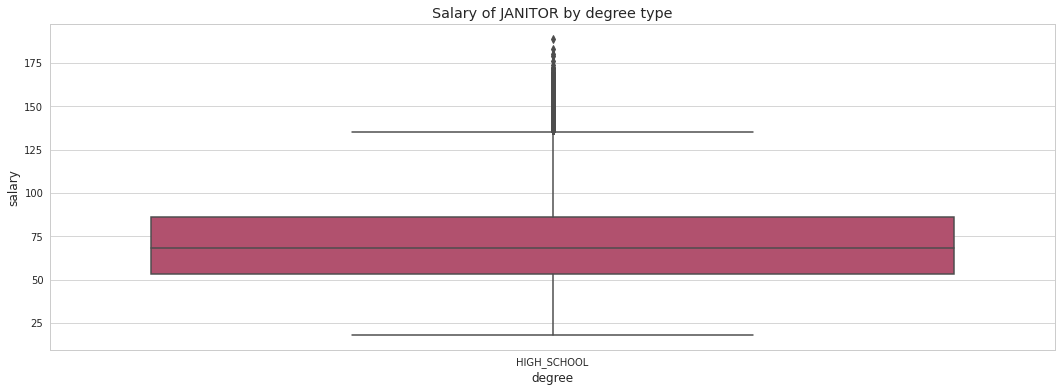

In [0]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(18,6))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

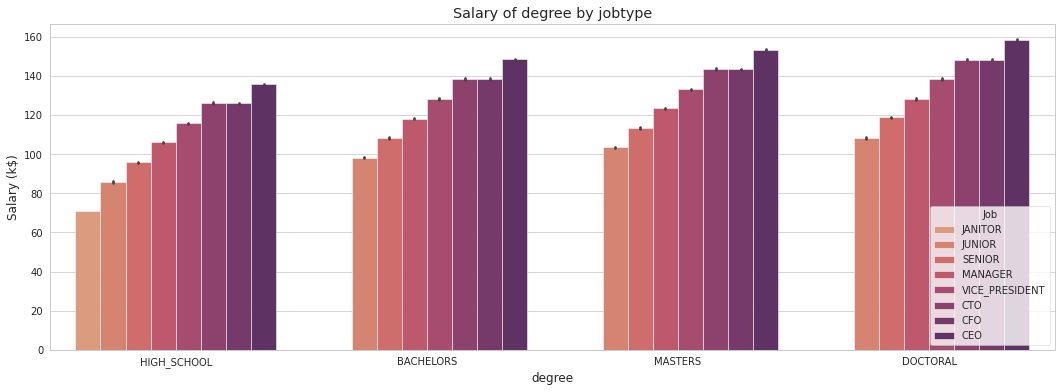

In [0]:
plt.figure(figsize=(18,6))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

Parece que, en todos los tipos de empleos de este conjunto de datos, los trabajadores con mayor nivel educativo cobran más. En particular, podemos observar una mayor diferencia de salarios entre los que tienen estudios secundarios y los que tienen estudios universitarios. Por último, es interesante observar que, en el caso del tipo de empleo CONSERJE, solo hay personas con estudios secundarios.

¿El mayor afecta el salario?

In [0]:
df_q7 = spark.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|       NONE| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



¡Aún tenemos valores `NONE` en grado y también en especialidad (nota: si el grado=Escuela secundaria, por supuesto la especialidad debe ser NINGUNA!), eliminaremos estos valores!

In [0]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [0]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|    COMPSCI|58382|
|       MATH|57800|
| LITERATURE|58684|
+-----------+-----+



In [0]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



En este marco de datos no hay `JANITOR` como tipo de trabajo: significa que todas las personas con `janitor` como tipo de trabajo en el conjunto de datos tienen "Escuela secundaria" como título y, por lo tanto, no tienen especialidad (como se indicó en la consulta anterior Q6). ¡Necesitamos definir una nueva lista de trabajos sin conserje para los siguientes gráficos!

In [0]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [0]:
df_p = df_q7.toPandas()

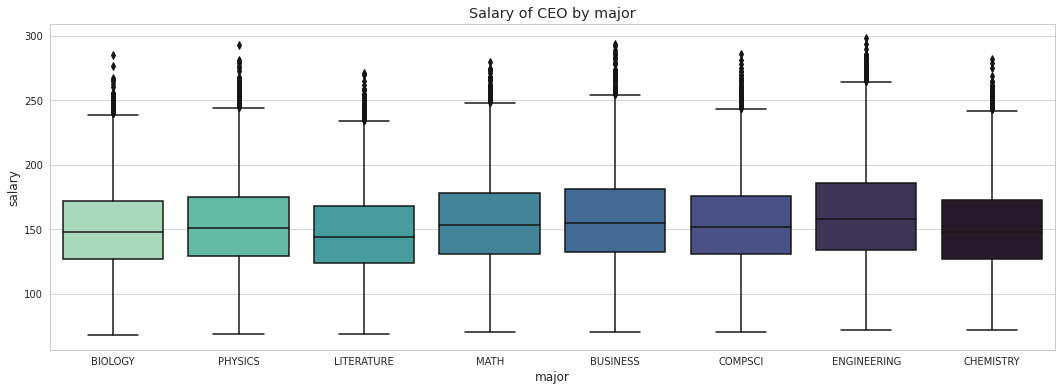

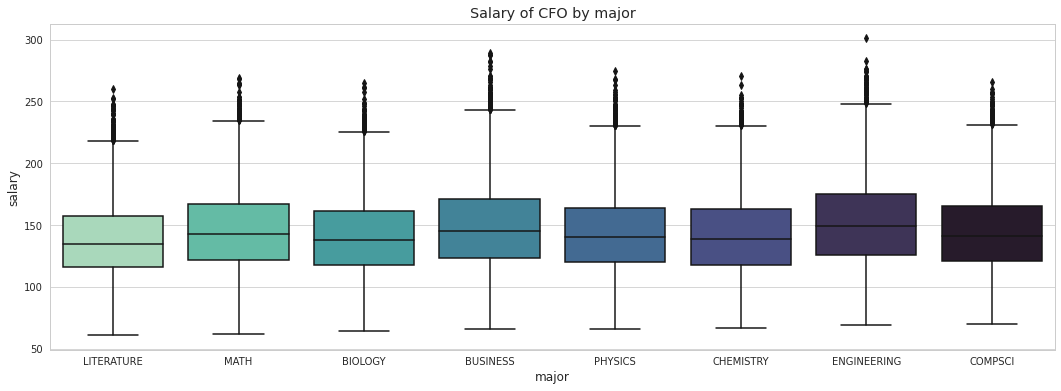

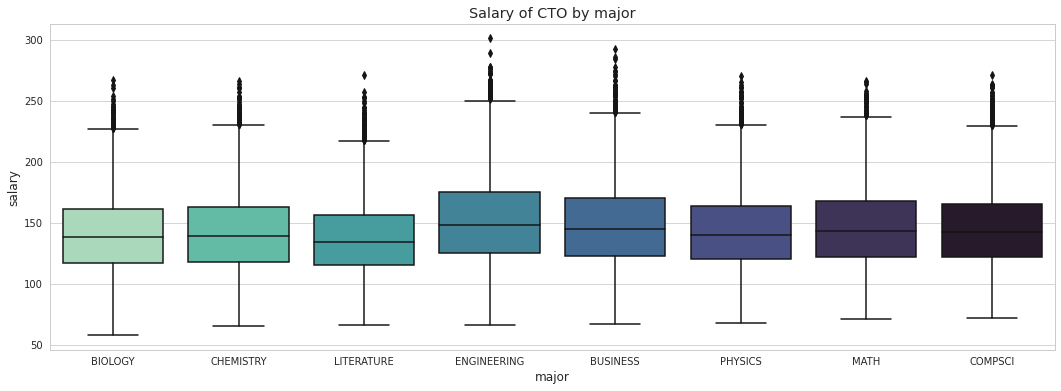

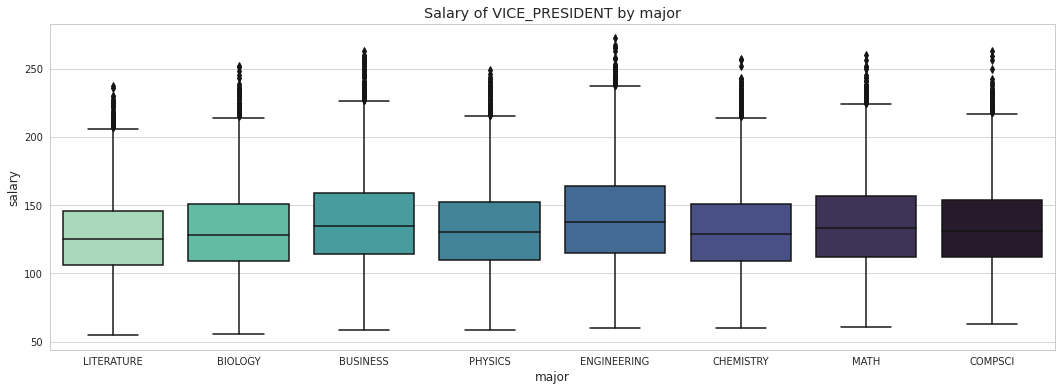

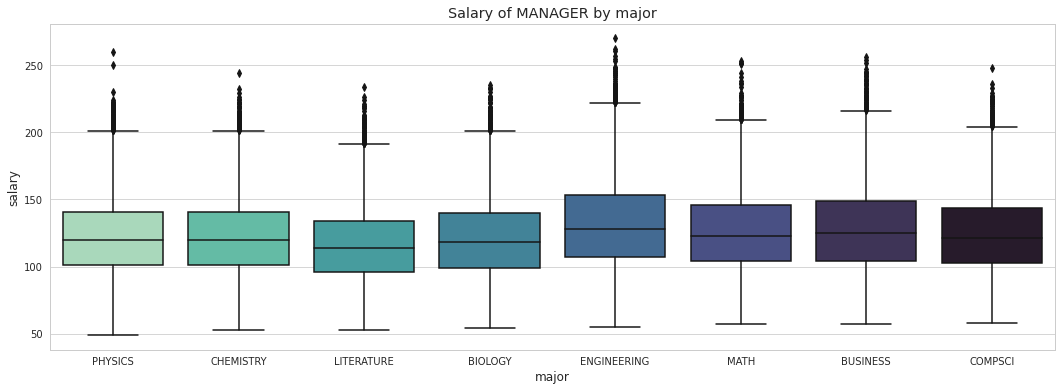

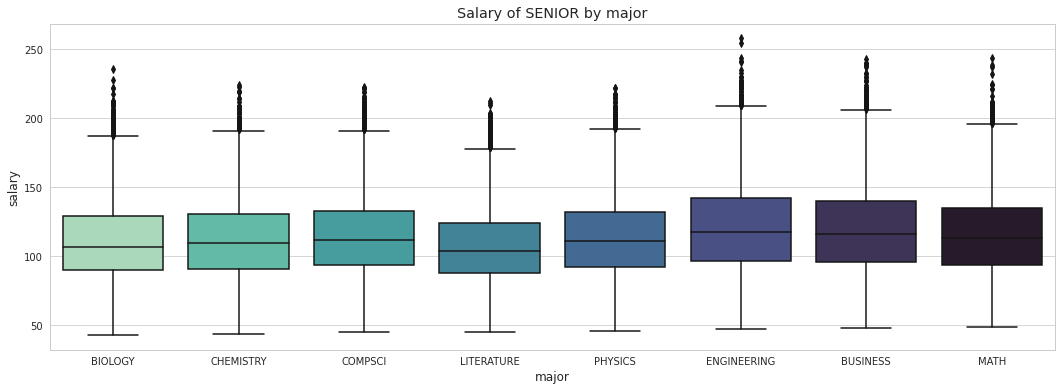

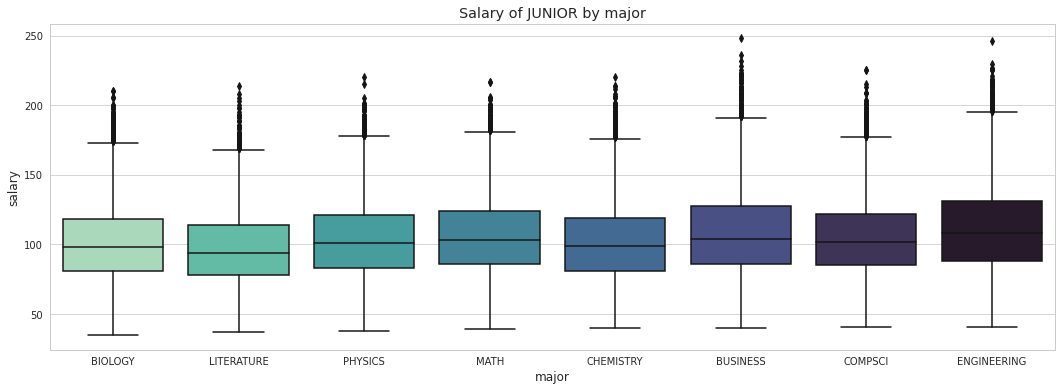

In [0]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(18,6))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

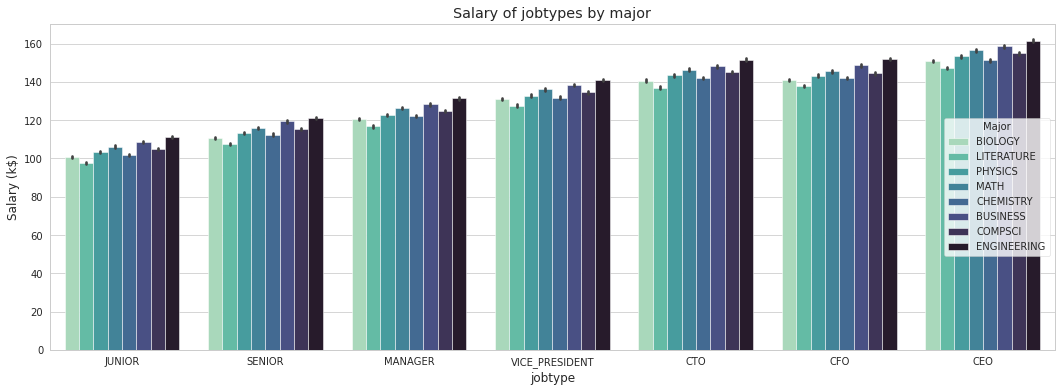

In [0]:
plt.figure(figsize=(18,6))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

Podemos observar que ingeniería es la carrera de los trabajadores con salarios más altos, negocios es la segunda y mientras que literatura es la carrera de los trabajadores con trabajos peor pagados.